In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings  
using CSV, DataFrames
using Zygote, Optim, ForwardDiff
using KernelFunctions, MAT, LoopVectorization

In [3]:
include("UniSGPnode.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

## Import data

In [4]:
data = CSV.read("BTC-USD.csv", DataFrame);
y_data =data[:,5];

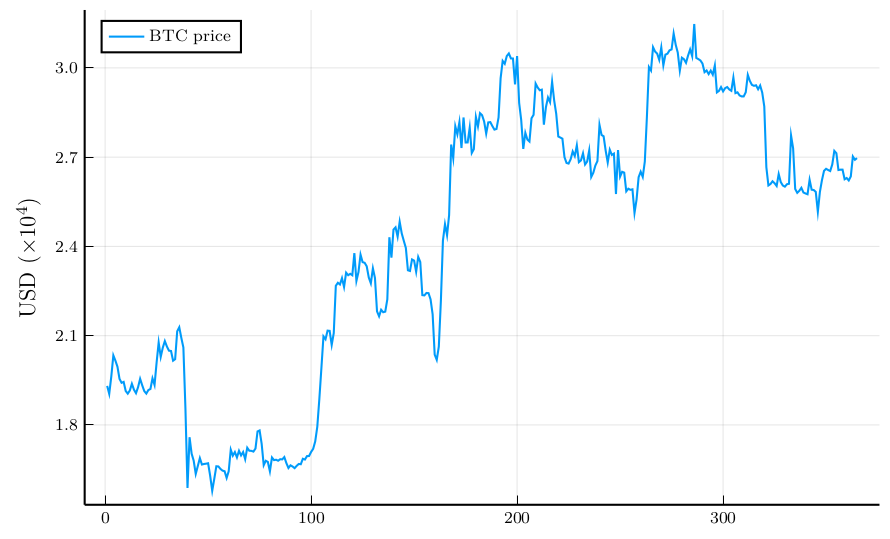

In [5]:
plot(y_data ./ 10^4,label="BTC price",legend=:topleft)
ylabel!("USD (×10⁴)")

In [6]:
savefig("texfiles/HGF_real_data.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/HGF_real_data.svg"

## GCV model

In [7]:
@model function gcv_hgf(y)
    z2_prev ~ NormalMeanVariance(0.,50.)
    z1_prev ~ NormalMeanVariance(0.,50.)

    k ~ NormalMeanVariance(1.,1)
    w ~ NormalMeanVariance(0.,1)
    ζ ~ GammaShapeRate(0.01,0.01)
    for i=1:length(y)
        z2[i] ~ NormalMeanPrecision(z2_prev,ζ) #upper layer
        z1[i] ~ GCV(z1_prev, z2[i], k,w) ## lower layer
        y[i] ~ NormalMeanVariance(z1[i],0.01)
        z2_prev = z2[i]
        z1_prev = z1[i]
    end
end

@constraints function hgfconstraints() 
    q(z1, z2, z2_prev, z1_prev,w,k,ζ) = q(z1,z1_prev)q(z2,z2_prev)q(w)q(ζ)q(k)
end

@meta function hgfmeta()
    GCV() -> GCVMetadata(GaussHermiteCubature(31)) 
end

hgf_init = @initialization begin
    q(z1) = NormalMeanVariance(0,50)
    q(z2) = NormalMeanVariance(0,50)
    q(k) = NormalMeanVariance(1,0.1)
    q(w) = NormalMeanVariance(0,1)
    q(ζ) = GammaShapeRate(0.01,0.01)
end
;

In [8]:
GCV_infer = infer(
    model = gcv_hgf(),
    data = (y = y_data,),
    meta = hgfmeta(),
    constraints = hgfconstraints(),
    initialization = hgf_init,
    iterations = 300,
    returnvars = (z1 = KeepLast(), z2 = KeepLast(), w=KeepLast(),k=KeepLast(),ζ = KeepLast(),),
)
;

In [9]:
qz1_gcv = GCV_infer.posteriors[:z1]
qz2_gcv = GCV_infer.posteriors[:z2]
qw_gcv = GCV_infer.posteriors[:w]
qk_gcv = GCV_infer.posteriors[:k]
qζ_gcv = GCV_infer.posteriors[:ζ]
;

## HGF with SGP node

In [10]:
## Exponential node 
struct ExpNormal end

@node ExpNormal Stochastic [ y, x, z ]   ## f(y,x,z) = NormalMeanVariance(y| x, exp(z))

######
@rule ExpNormal(:y, Marginalisation) (q_x::Any, q_z::Any) = begin
    μ_z, v_z = mean_var(q_z)
    return NormalMeanPrecision(mean(q_x), exp(-μ_z + clamp(v_z,1e-12,1e12)/2))
end

@rule ExpNormal(:x, Marginalisation) (q_y::Any, q_z::Any) = begin
    μ_z, v_z = mean_var(q_z)
    return NormalMeanPrecision(mean(q_y), exp(-μ_z + clamp(v_z,1e-12,1e12)/2))
end

@rule ExpNormal(:z, Marginalisation) (q_y::Any, q_x::Any) = begin
    μ_y, v_y = mean_var(q_y)
    μ_x, v_x = mean_var(q_x)

    log_backwardmess = (z) -> -0.5*z - 0.5 * (1/exp(z)) * (μ_y^2 + v_y -2*μ_y * μ_x + μ_x^2 + v_x)
    return ContinuousUnivariateLogPdf(log_backwardmess)
end


@average_energy ExpNormal (q_y::Any, q_x::Any, q_z::Any) = begin
    μ_z, v_z = mean_var(q_z)
    μ_y, v_y = mean_var(q_y)
    μ_x, v_x = mean_var(q_x)
    γ = exp(-μ_z + clamp(v_z,1e-12,1e12)/2)
    return 0.5*log(2π) + 0.5*μ_z + 0.5* γ * (μ_y^2 + v_y -2*μ_y * μ_x + μ_x^2 + v_x)
end



### Model with SGP

In [11]:
@model function gp_HFG1(y,dim_v,θ)
    z2_prev ~ NormalMeanVariance(0, 50.)
    z1_prev ~ NormalMeanVariance(0, 50.)
    v ~ MvNormalMeanCovariance(zeros(dim_v), 0.01diageye(dim_v))
    w ~ GammaShapeRate(0.01,0.01)
    ζ ~ GammaShapeRate(0.01,0.01)

    for i=1:length(y)
        z2[i] ~ NormalMeanPrecision(z2_prev,ζ) 
        h[i] ~ UniSGP(z2[i],v,w,θ) 
        z1[i] ~ ExpNormal(z1_prev, h[i])
        y[i] ~ NormalMeanVariance(z1[i], 0.01)
        z2_prev = z2[i]
        z1_prev = z1[i]
    end
end

In [12]:
Nu = 50; #number of inducing points 
dim_v = Nu;
Xu = range(-20,20;length=Nu);
kernel_gp(θ) = θ[1] * with_lengthscale(Matern52Kernel(),θ[2]) 

kernel_gp (generic function with 1 method)

In [13]:
@meta function meta_gp_HFG1(method,Xu, kernel)
    UniSGP() -> UniSGPMeta(method,Xu,kernel)
end

gp_constraint = @constraints begin
    q(z1,z2,z1_prev,z2_prev,v,w,h,ζ) = q(z1)q(z2)q(z1_prev)q(z2_prev)q(v)q(w)q(h)q(ζ)
    q(z1) = q(z1[begin])..q(z1[end])
    q(z2) = q(z2[begin])..q(z2[end])
end

gp_init = @initialization begin
    q(v) = MvNormalMeanCovariance(zeros(dim_v), 0.01diageye(dim_v))
    q(h) = NormalMeanVariance(0,1)
    q(z1) = NormalMeanVariance(0,50.)
    q(z2) = NormalMeanVariance(0,50.)
    q(w) = GammaShapeRate(0.01,0.01)
    q(ζ) =  GammaShapeRate(0.01,0.01)
end
;

## Optimize hyperparameters

In [14]:
function my_free_energy(θ)
    infer_result = infer(
        model = gp_HFG1(dim_v = dim_v, θ = θ,),
        data = (y = y_data,),
        iterations = 75,
        initialization = gp_init,
        constraints = gp_constraint,
        meta = meta_gp_HFG1(GenUnscented(),Xu,kernel_gp),
        returnvars = (z1 = KeepLast(),z2 = KeepLast(),v = KeepLast(), w = KeepLast(), ζ = KeepLast(),h = KeepLast(),),
        free_energy = true
    )
    return infer_result.free_energy[end]
end

function learn_params(θ,iter)
    lower = [1,1]
    upper = [15,15]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iter))
    return res.minimizer
end

learn_params (generic function with 1 method)

In [15]:
#this will take ~28min
θ_init = [5., 2.]
θ_optimal = learn_params(θ_init,1)

2-element Vector{Float64}:
 12.259375
  3.4734375

## SGP inference

In [16]:
niter =300
infer_result = infer(
    model = gp_HFG1(dim_v = dim_v, θ = θ_optimal,),
    data = (y = y_data,),
    iterations = niter,
    initialization = gp_init,
    constraints = gp_constraint,
    meta = meta_gp_HFG1(GenUnscented(),Xu,kernel_gp),
    returnvars = (z1 = KeepLast(),z2 = KeepLast(),v = KeepLast(), w = KeepLast(), ζ = KeepLast(),h = KeepLast(),),
    free_energy =true
)
;

In [18]:
qz1_sgp = infer_result.posteriors[:z1]
qz2_sgp = infer_result.posteriors[:z2]
qv_sgp = infer_result.posteriors[:v]
qw_sgp = infer_result.posteriors[:w]
qζ_sgp = infer_result.posteriors[:ζ]
qh_sgp = infer_result.posteriors[:h]
;

## Compare results

In [19]:
function gp_predict(x_test,qv,qw,qθ, meta)
    prediction = @call_rule UniSGP(:out, Marginalisation) (q_in=x_test,q_v = qv, q_w = qw,q_θ = qθ, meta=meta)
    return prediction
end

function gcv_predict(upper_state,qk, qw)
    mz, vz = mean_var(upper_state)
    mk, vk = mean_var(qk)
    zk = NormalMeanVariance(mz * mk, mz^2 * vk + mk^2 * vz + vz * vk)
    return @call_rule typeof(+)(:out, Marginalisation) (m_in1=zk, m_in2 = qw)
end

gcv_predict (generic function with 1 method)

In [20]:
gp_predict_mean =[]
gp_predict_var =[]
for i=1:length(qz2_sgp)
    prediction = gp_predict(qz2_sgp[i],qv_sgp,qw_sgp,PointMass(θ_optimal), UniSGPMeta(GenUnscented(),Xu,kernel_gp))
    append!(gp_predict_mean,mean(prediction))
    append!(gp_predict_var,var(prediction)) 
end

gcv_predict_mean =[]
gcv_predict_var =[]
for i=1:length(qz2_gcv)
    prediction = gcv_predict(qz2_gcv[i],qk_gcv,qw_gcv)
    append!(gcv_predict_mean,mean(prediction))
    append!(gcv_predict_var,var(prediction)) 
end

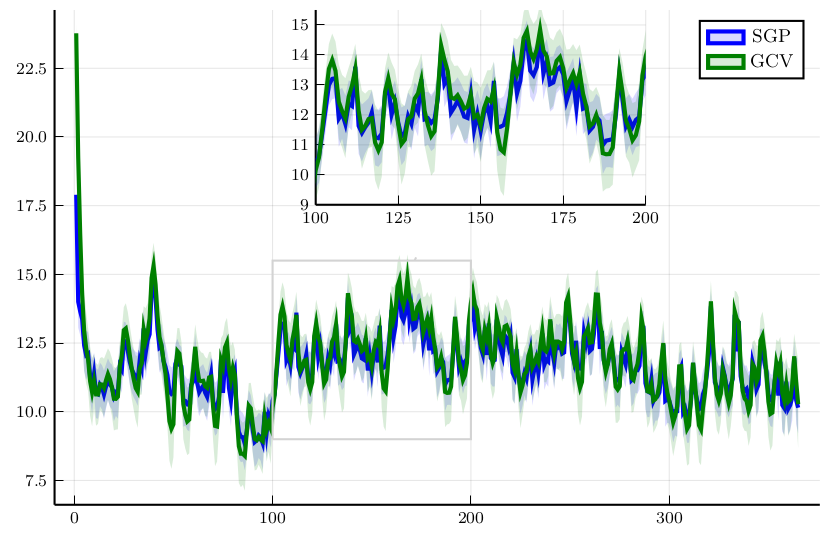

In [22]:
plot(mean.(qh_sgp), ribbon = std.(qh_sgp) .+ 1e-7,
    lw=2,
    label = "SGP",
    color=:blue,
    legend=:topright,
    fillalpha=0.15, fontfamily="monospace",legendfontsize=9)

    # plot(gp_predict_mean, ribbon = sqrt.(gp_predict_var) .+ 1e-7,
    # lw=2,
    # label = "SGP",
    # color=:blue,
    # legend=:topright,
    # fillalpha=0.15, fontfamily="monospace",legendfontsize=9)
    
plot!(gcv_predict_mean, ribbon = sqrt.(gcv_predict_var .+ 1e-7),
    lw=2,
    label = "GCV",
    color = :green,
    fillalpha=0.15,
    alpha = 2)

lens!([100, 200], [9, 15.5], inset = (1, bbox(0.3, 0., 0.5, 0.5)))

In [23]:
savefig("texfiles/HGF_stateresult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/HGF_stateresult.svg"